In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.callbacks import ModelCheckpoint # new!
import os # new!
import time

In [2]:
batch_size = 10
box_plot_title = 'Memory Estimation Error (MB)'

# 1. Loading training and test datasets

In [3]:
def load_data():
    df = pd.read_csv('job_query_train.csv')
    
    feature_cols = ['TQ', 'TQ COUNT', 'TBSCAN', 'TBSCAN COUNT', 'HS JOIN', 'HS JOIN COUNT']
    
    target_col = ['actual']
    
    X = df[feature_cols]
    y = df[target_col]
    
    print('X.shape: ', X.shape)
    print('y.shape: ', y.shape)
    
    return X.values, y.values

def load_test_data():
    df = pd.read_csv('job_query_test.csv')
    
    feature_cols = ['TQ', 'TQ COUNT', 'TBSCAN', 'TBSCAN COUNT', 'HS JOIN', 'HS JOIN COUNT']
    
    target_cols = ['actual', 'db2']
    
    X = df[feature_cols]
    Y = df[target_cols]
    
    print('df_test shape: ', df.shape)
    
    return X, Y


def cross_validate(model):
    # Load data
    X, y = load_data()
    train_data = X.copy()
    train_targets = y.copy()

    k = 10
    num_val_samples = len(train_data) // k
    all_train_scores = []
    all_scores = []
    
    for i in range(k):
        print(f"Processing fold #{i}")
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                             train_data[(i + 1) * num_val_samples:]], axis=0)
        
        partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                                train_targets[(i + 1) * num_val_samples:]], axis=0)

        model.fit(partial_train_data, partial_train_targets)
    
        train_mse = mean_squared_error(partial_train_targets, model.predict(partial_train_data))
        val_mse = mean_squared_error(val_targets, model.predict(val_data))
    
        all_train_scores.append(train_mse)
        all_scores.append(val_mse)
    
    print('train rmse ', np.sqrt(np.mean(all_train_scores)))
    print('validation rmse ', np.sqrt(np.mean(all_scores)))

# create workloads for the given batch size
def batch(Y, batch_size=10):
    # generate integer values in range [0, number of records -1]
    indices = np.linspace(0, Y.shape[0]-1, Y.shape[0], dtype=int)
    #np.random.seed(42)
    #np.random.shuffle(indices)
    num_batches = int(np.floor(Y.shape[0] / batch_size))
    
    df_batches = pd.DataFrame(columns=Y.columns)
    
    for ibat in range(num_batches):
        start = (ibat * batch_size)
        end = (ibat * batch_size + batch_size) - 1
        
        ibat_Y = Y.loc[indices[start:end], :]
        
        df_batches = df_batches.append(ibat_Y.sum(), ignore_index=True)
        
    return df_batches

# Review this
def rmse(Y):
    cols = Y.columns.values[1:]
    rmse_dict = {}
    
    for col in cols:
        rmse = np.round(np.sqrt(mean_squared_error(Y['actual'].values, Y[col].values)))
        rmse_dict[col] = rmse
    
    return rmse_dict

def calculate_residuals(Y):
    first_col = Y.columns[0]
    cols = Y.columns[1:]
    df_residuals = pd.DataFrame(columns=cols)

    for col in cols:
        df_residuals[col] = Y[col] - Y[first_col]
        
    return df_residuals

def box_plot(Y):
    df_residuals = calculate_residuals(Y)
    sns.set_style("whitegrid", {'axes.grid' : False})
    f = plt.figure(figsize=[10,3])
    ax = f.add_subplot(111)
    sns.boxplot(data=df_residuals, ax=ax, showfliers = True, orient="h")
    ax.set_xlabel(xlabel=box_plot_title,fontsize=13)
    #plt.tick_params(axis='x',labeltop='on', labelbottom='on')
    #ax.xaxis.set_ticks_position('both')
    
    f.tight_layout()
    
    plt.savefig('JOB_query_boxplot.png', dpi=150)

In [4]:
X, y = load_data()

X.shape:  (1865, 6)
y.shape:  (1865, 1)


In [5]:
load_test_data()

df_test shape:  (467, 8)


(           TQ  TQ COUNT    TBSCAN  TBSCAN COUNT   HS JOIN  HS JOIN COUNT
 0    0.065215       0.0  1.008923      0.819236 -0.057920       0.819236
 1    0.056780       0.0  1.008923      0.819236 -0.057922       0.819236
 2   -0.162551       0.0 -1.208890     -1.220650 -0.065235      -1.220650
 3   -0.145175       0.0  0.635903      0.819236 -0.057915       0.819236
 4   -0.161825       0.0 -1.208888     -1.220650 -0.063914      -1.220650
 ..        ...       ...       ...           ...       ...            ...
 462  0.056780       0.0  1.008923      0.819236 -0.057922       0.819236
 463 -0.115518       0.0  0.685405      0.819236 -0.055388       0.819236
 464 -0.120384       0.0  0.685404      0.819236 -0.055388       0.819236
 465 -0.162551       0.0 -1.208890     -1.220650 -0.065234      -1.220650
 466  0.065215       0.0  1.008923      0.819236 -0.057920       0.819236
 
 [467 rows x 6 columns],
       actual      db2
 0    251.248  251.248
 1    251.252  251.248
 2     57.124  5

# Ridge

In [6]:
# Load data
X, y = load_data()

ridge = Ridge(random_state=33)
cross_validate(ridge)

ridge.fit(X, y)

X.shape:  (1865, 6)
y.shape:  (1865, 1)
X.shape:  (1865, 6)
y.shape:  (1865, 1)
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
train rmse  25.26601806007261
validation rmse  25.450379462077894


Ridge(random_state=33)

# Decision Tree

In [7]:
# Load data
X, y = load_data()

tree = DecisionTreeRegressor(
    max_features=None, random_state=33)

cross_validate(tree)

tree.fit(X, y)

X.shape:  (1865, 6)
y.shape:  (1865, 1)
X.shape:  (1865, 6)
y.shape:  (1865, 1)
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
train rmse  9.756849720698373
validation rmse  11.89621049254511


DecisionTreeRegressor(random_state=33)

# Random Forest

In [8]:
# Load data
X, y = load_data()

forest = RandomForestRegressor(
    n_estimators=10, random_state=33
)

cross_validate(forest)

forest.fit(X, y)

X.shape:  (1865, 6)
y.shape:  (1865, 1)
X.shape:  (1865, 6)
y.shape:  (1865, 1)
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9


/var/folders/1v/zdszy15n595bb2xxfx_p9bhw0000gn/T/ipykernel_32071/3056831869.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(partial_train_data, partial_train_targets)
/var/folders/1v/zdszy15n595bb2xxfx_p9bhw0000gn/T/ipykernel_32071/3056831869.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(partial_train_data, partial_train_targets)
/var/folders/1v/zdszy15n595bb2xxfx_p9bhw0000gn/T/ipykernel_32071/3056831869.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(partial_train_data, partial_train_targets)
/var/folders/1v/zdszy15n595bb2xxfx_p9bhw0000gn/T/ipykernel_32071/3056831869.py:53: DataConversionWarning: A column-vector

train rmse  9.93466399010248
validation rmse  11.596688164386748


/var/folders/1v/zdszy15n595bb2xxfx_p9bhw0000gn/T/ipykernel_32071/334396991.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X, y)


RandomForestRegressor(n_estimators=10, random_state=33)

# XGBoost

In [9]:
# Load data
X, y = load_data()

xgb_regressor = XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    colsample_bylevel=1,
    colsample_bynode=1,
    colsample_bytree=1,
    gamma=0,
    gpu_id=-1,
    interaction_constraints="",
    learning_rate=0.300000012,
    max_delta_step=0,
    max_depth=3,
    min_child_weight=1,
    missing=float("nan"),
    monotone_constraints="()",
    n_estimators=879,
    num_parallel_tree=1,
    random_state=33,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    subsample=1,
    tree_method="exact",
    validate_parameters=1,
    verbosity=0,
    silent=False,
    nthread=4,
    seed=33,
)

cross_validate(xgb_regressor)

xgb_regressor.fit(X, y)

X.shape:  (1865, 6)
y.shape:  (1865, 1)
X.shape:  (1865, 6)
y.shape:  (1865, 1)
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
train rmse  9.680531722500321
validation rmse  12.018410498024384


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=879, n_jobs=4, nthread=4, num_parallel_tree=1,
             random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=33, silent=False, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

# DNN using Scikit-learn

In [10]:
dnn_model = MLPRegressor(hidden_layer_sizes=(64,64,32),
                       max_iter = 100,activation = 'relu',
                       solver = 'adam')
cross_validate(dnn_model)

dnn_model.fit(X, y)

X.shape:  (1865, 6)
y.shape:  (1865, 1)
Processing fold #0


/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #1


/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #2


/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #3


/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #4


/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #5


/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #6


/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #7


/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #8


/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #9


/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train rmse  24.17245203847888
validation rmse  24.413847625049677


/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(64, 64, 32), max_iter=100)

# All Final Models

In [11]:
X_test, Y_test = load_test_data()

df_test shape:  (467, 8)


## Computing Inference Latency

In [12]:
latency_sum = 0

for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    tree.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

tree_time = np.round(latency_sum / X_test.shape[0] * batch_size * 1000000, 1)

print('tree: ', tree_time, ' μs')

tree:  1135.0  μs


In [13]:
latency_sum = 0

for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    forest.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

forest_time = np.round(latency_sum / X_test.shape[0] * batch_size * 1000000, 1)

print('forest: ', forest_time, ' μs')

forest:  9986.1  μs


In [14]:
latency_sum = 0

for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    xgb_regressor.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

xgb_time = np.round(latency_sum / X_test.shape[0] * batch_size * 1000000, 1)

print('xgb: ', xgb_time, ' μs')

xgb:  996.0  μs


In [15]:
latency_sum = 0

for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    ridge.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

ridge_time = np.round(latency_sum / X_test.shape[0] * batch_size * 1000000, 1)

print('ridge: ', ridge_time, ' μs')

ridge:  662.5  μs


In [16]:
latency_sum = 0

for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    dnn_model.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

dnn_time = np.round(latency_sum / X_test.shape[0] * batch_size * 1000000, 1)

print('dnn: ', dnn_time, ' μs')

dnn:  998.5  μs


## Generating Predictions

In [17]:
Y_test['tree'] = tree.predict(X_test.values)
Y_test['forest'] = forest.predict(X_test.values)
Y_test['xgb'] = xgb_regressor.predict(X_test.values)
Y_test['ridge'] = ridge.predict(X_test.values)
Y_test['dnn'] = dnn_model.predict(X_test.values)

# Computing model sizes

In [18]:
import sys
import pickle

In [19]:
# size of the ridge model
p = pickle.dumps(ridge)
print('Ridge:', sys.getsizeof(p) / 1024)

# size of the tree model
p = pickle.dumps(tree)
print('Decision Tree:', sys.getsizeof(p) / 1024)

# size of the forest model
p = pickle.dumps(forest)
print('Random Forest:', sys.getsizeof(p) / 1024)

# size of the xgboost model
p = pickle.dumps(xgb_regressor)
print('XGBoost:', sys.getsizeof(p) / 1024)

# size of the dnn model
p = pickle.dumps(dnn_model)
print('DNN:', sys.getsizeof(p) / 1024)

Ridge: 0.5361328125
Decision Tree: 25.6708984375
Random Forest: 220.173828125
XGBoost: 947.3212890625
DNN: 163.919921875


# Creating Batches

In [20]:
# creating batches
Y_test_batch = batch(Y_test, batch_size)

In [21]:
Y_test_batch.head()

,actual,db2,tree,forest,xgb,ridge,dnn
0,1578.396,3006.988,1585.663703,1583.820729,1580.692627,1544.282099,1525.659254
1,1070.720,3829.064,1066.728834,1066.239446,1066.722656,1052.596066,1096.028012
2,1147.360,3477.612,1101.182858,1100.338928,1098.089478,1104.035575,1100.169798
3,1284.616,3649.988,1269.454354,1265.628531,1269.462402,1227.628750,1198.578673
4,911.604,4200.320,870.647962,866.810505,870.633789,899.355404,861.443125


In [22]:
Y_test_batch = Y_test_batch[['actual', 'db2', 'tree', 'forest', 'xgb', 'ridge', 'dnn']]

In [23]:
print('Test RMSE')
print(rmse(Y_test_batch))

Test RMSE
{'db2': 2034.0, 'tree': 30.0, 'forest': 30.0, 'xgb': 34.0, 'ridge': 74.0, 'dnn': 71.0}


BOX PLOT


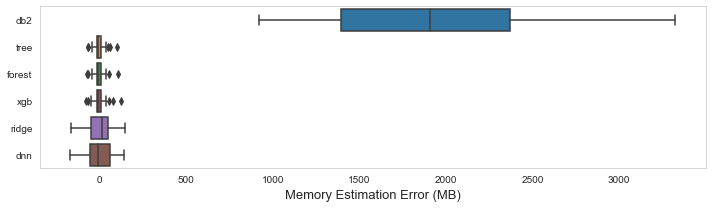

In [24]:
print('BOX PLOT')
box_plot(Y_test_batch)

In [25]:
Y_test_batch.shape

(46, 7)

In [26]:
Y_test_batch.head()

,actual,db2,tree,forest,xgb,ridge,dnn
0,1578.396,3006.988,1585.663703,1583.820729,1580.692627,1544.282099,1525.659254
1,1070.720,3829.064,1066.728834,1066.239446,1066.722656,1052.596066,1096.028012
2,1147.360,3477.612,1101.182858,1100.338928,1098.089478,1104.035575,1100.169798
3,1284.616,3649.988,1269.454354,1265.628531,1269.462402,1227.628750,1198.578673
4,911.604,4200.320,870.647962,866.810505,870.633789,899.355404,861.443125


# Inter-Quartile Range (IQR)

In [27]:
residuals = calculate_residuals(Y_test_batch)

In [28]:
np.percentile(residuals['db2'], [25, 75])

array([1393.65 , 2366.734])

In [29]:
np.percentile(residuals['ridge'], [25, 75])

array([-52.0087458 ,  48.87434744])

In [30]:
np.percentile(residuals['tree'], [25, 75])

array([-17.48840457,   7.5888406 ])

In [31]:
np.percentile(residuals['forest'], [25, 75])

array([-17.47030057,   5.25924784])

In [32]:
np.percentile(residuals['xgb'], [25, 75])

array([-18.20476843,   7.17996692])

In [33]:
np.percentile(residuals['dnn'], [25, 75])

array([-55.88496521,  62.11389794])

# Training Time

In [34]:
latency_sum = 0

for i in range(5):
    time_start = time.time()
    ridge.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('ridge training time: ', train_time, ' ms')

latency_sum = 0

for i in range(5):
    time_start = time.time()
    tree.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('tree training time: ', train_time, ' ms')

latency_sum = 0

for i in range(5):
    time_start = time.time()
    forest.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('forest training time: ', train_time, ' ms')

latency_sum = 0

for i in range(5):
    time_start = time.time()
    xgb_regressor.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('xgb training time: ', train_time, ' ms')

latency_sum = 0

for i in range(5):
    time_start = time.time()
    dnn_model.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('dnn training time: ', train_time, ' ms')

ridge training time:  1.0  ms
tree training time:  1.9  ms
forest training time:  18.8  ms


/var/folders/1v/zdszy15n595bb2xxfx_p9bhw0000gn/T/ipykernel_32071/4269665725.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X, y)
/var/folders/1v/zdszy15n595bb2xxfx_p9bhw0000gn/T/ipykernel_32071/4269665725.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X, y)
/var/folders/1v/zdszy15n595bb2xxfx_p9bhw0000gn/T/ipykernel_32071/4269665725.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X, y)
/var/folders/1v/zdszy15n595bb2xxfx_p9bhw0000gn/T/ipykernel_32071/4269665725.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using 

xgb training time:  300.1  ms


/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer:

dnn training time:  825.7  ms


/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
calculate_residuals(Y_test_batch).to_csv('job-query-residuals.csv')